In [1]:
import xarray as xr
import numpy as np
import datetime
import pandas as pd

def load_data(var, init_times, area=None):
    var_inits = []
    for t0 in init_times:
        yyyymmddhh = t0.strftime('%Y%m%d%H')
        file = f'/home/bernatj/Data/ai-forecasts/fcst/{yyyymmddhh}/{var}_fcnv2_{yyyymmddhh}.nc'
        ds = xr.open_dataset(file, chunks={'time': 10})[var]  # Enable lazy loading with Dask
        if area:
            ds = ds.sel(area)
        var_inits.append(ds)
    merged_dataset = xr.concat(var_inits, dim='init_time')
    return merged_dataset.assign_coords(init_time=init_times)


def flip_lon_360_2_180(var_360, lon):
    """
    This function shifts the longitude dimension from [0,360] to [-180,180].
    """
    try:
        var_180 = var_360.assign_coords(lon=(lon + 180) % 360 - 180)
        var_180 = var_180.sortby(var_180.lon)
    except:
        var_180 = var_360.assign_coords(longitude=(lon + 180) % 360 - 180)
        var_180 = var_180.sortby(var_180.longitude)

    return var_180

def from_init_time_to_leadtime(var_init_time, init_time_min, lead_time_range, time_range):
    """
    This function creates a xarray DataArray for a given variable and fills it with values based on the provided time range and lead time range.

    Parameters:
    var_init_time (xarray.DataArray): The initial time data for the variable.
    init_time_min (datetime): The minimum initial time.
    lead_time_range (numpy.ndarray): The range of lead times.
    time_range (pandas.DatetimeIndex): The range of times.

    Returns:
    xarray.DataArray: The created and filled DataArray for the variable.
    """

    # Create a new DataArray for the variable with extra dimensions
    dims = ["lead_time", "time"] + list(var_init_time.dims)[2:]
    coords = {"lead_time": lead_time_range, "time": time_range}
    coords.update({dim: var_init_time.coords[dim] for dim in var_init_time.dims[2:]})
    var_leadtime = xr.DataArray(dims=dims, coords=coords)
    
    # Loop to assign values
    for t in time_range:
        for lt in lead_time_range:
            # Convert the numpy datetime64 object to a Python datetime object
            t_datetime = pd.to_datetime(str(t.values))

            # Subtract the timedelta
            it = t_datetime - datetime.timedelta(hours=int(lt))

            # Assign NaN if the initial time is less than the minimum initial time
            if it < init_time_min:
                var_leadtime.loc[{"lead_time": lt, "time": t}] = np.nan
            else:
                try:
                    # Assign the value from the initial time data for the variable
                    var_leadtime.loc[{"lead_time": lt, "time": t}] = var_init_time.sel(init_time=it, time=t)
                except:
                    # Assign NaN if the value cannot be assigned
                    var_leadtime.loc[{"lead_time": lt, "time": t}] = np.nan

    return var_leadtime

In [2]:
# we want to see if due to the different period the model is trained if there are trends in the evolution of global mean quantities.

In [3]:
#we want to run our model for different dates
t0_i = datetime.datetime(2022,7,1,0)
t0_f = datetime.datetime(2022,7,10,18)
delta_h = 6
# number of forecast steps
num_steps = 4 * 15 # 6h intervals

init_times = []
current_time = t0_i
while current_time <= t0_f:
    init_times.append(current_time)
    current_time += datetime.timedelta(hours=delta_h)

In [4]:
#load data
t2m_ai = load_data('t2m',init_times)

In [5]:
def global_mean(var):
    lat=var.lat
    weights = np.cos(lat*np.pi/180)
    print(np.sum(weights))
    glob_mean = ((var*weights).sum('lat')/np.sum(weights)).mean('lon')
    return glob_mean

In [6]:
t2m_ai_gm = (global_mean(t2m_ai) - 273.15).load()

<xarray.DataArray 'lat' ()> Size: 8B
array(458.36550888)


In [7]:
#from init time to lead time
time_range = t2m_ai.time.sel(time=slice('2022-07-01','2022-07-20'))
init_time_min = datetime.datetime(2022, 7, 1, 0)
lead_time_range = np.arange(0,15*24,6)

t2m_gm_lt = from_init_time_to_leadtime(t2m_ai_gm, init_time_min, lead_time_range, time_range)

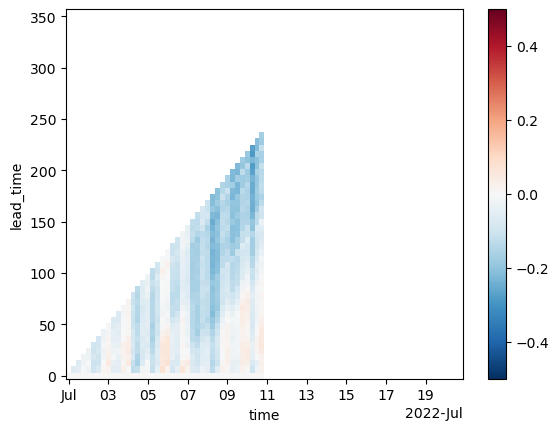

In [8]:
(t2m_gm_lt - t2m_gm_lt[0]).plot(vmin=-0.5,vmax=0.5,cmap='RdBu_r')

In [9]:
def load_data_deltas(var, init_times, models):
    var_inits_model = []
    for model in models:
        print(model)
        var_inits = []
        for t0 in init_times:
            yyyymmddhh = t0.strftime('%Y%m%d%H')    
            file = f'/home/bernatj/Data/ai-forecasts/fcst/{yyyymmddhh}/{var}_fcnv2_PGW_{model}_{yyyymmddhh}.nc'
            ds = xr.open_dataset(file)[var]
            var_inits.append(ds)
        var_inits_model.append(xr.concat(var_inits, dim='init_time'))
    merged_dataset = xr.concat(var_inits_model, dim='model')
    return merged_dataset.assign_coords(init_time=init_times,model=models)

t2m_pgw = load_data_deltas('t2m',init_times,['multimodel']).squeeze()

multimodel


In [10]:
t2m_pgw_gm = (global_mean(t2m_pgw) - 273.15)

<xarray.DataArray 'lat' ()> Size: 8B
array(458.36550888)
Coordinates:
    model    <U10 40B 'multimodel'


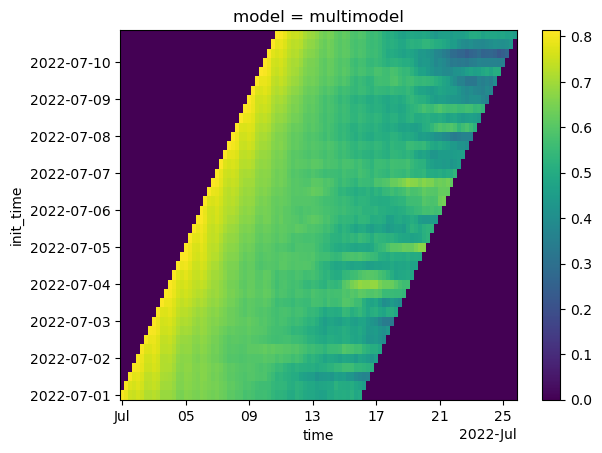

In [11]:
(t2m_ai_gm - t2m_pgw_gm)..plot() 

In [12]:
t2m_gm_pgw_lt = from_init_time_to_leadtime(t2m_pgw_gm, init_time_min, lead_time_range, time_range)

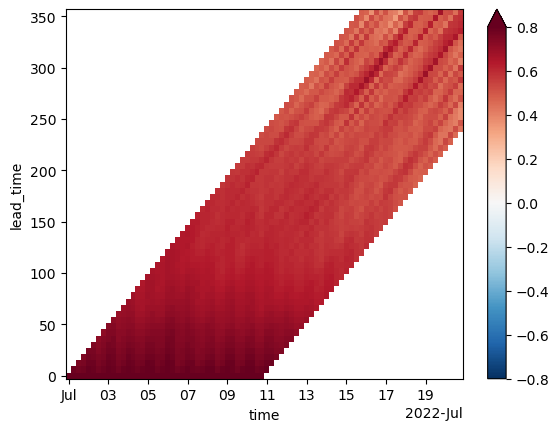

In [16]:
(t2m_gm_lt - t2m_gm_pgw_lt).plot(y=,cmap='RdBu_r', vmax=0.8, vmin=-0.8) 

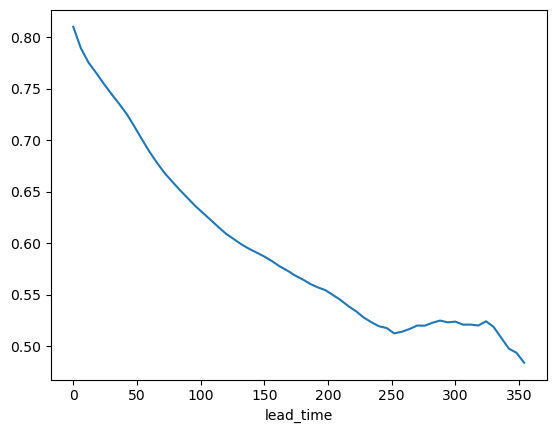

In [17]:
(t2m_gm_lt - t2m_gm_pgw_lt).mean('time').plot() 